In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from math import pow

In [2]:
small=0
CN=17
mi=0.0028 #FROM OPLO
t=np.linspace(0, 600) 
NA=6.2*10**(23)
#for transcription and translation rates of constructs
pluxr=155*60*10**(-3)
kluxr=27*60*10**(-3)
a1=pluxr*kluxr
plux_repr=3.69*10**(-3)*60
kphlf=4*10**(-3)*60
a2=plux_repr*kphlf
phybrid=10*60*10**(-3)
kmng=18.3*60*10**(-3)
a3=phybrid*kmng
n=2
#leakiness of promoters
b_plux=0.1 #FROM OPLO
b_pphlf=0.1
#for luxr-ahl dimer
kd1=100*10**(-9)
kd2=20*10**(-9)
k_min_one=10
k_min_two=1
k1=k_min_one/kd1
k2=k_min_two/kd2
kdlux=10*10**(-9) #FROM OPLO
kdlux_repr=kdlux
kdphlf=2*10**(-7)
#degradation rates
d_mrnamng=0.023 #FROM OPLO 
d_mng=0.019 #FROM OPLO
d_mrnaluxr=0.347
d_mon=0.156
d_dim=0.017
d_luxr=0.002
d_AHL=0.01
d_mrnaphlf=0.02*60
d_phlf=0.042
#for Diffusion
D=10
Nmin=0.129*10**(7)
Nmax=2.142*10**(7)
Vecoli=10**(-15)
Vbead=200*10**(-6)
Vc=Vecoli/Vbead


In [3]:
#functions for biochemical equations
def molecules(number): #turns nM to molecules
    return number*NA*10**(-15)

def molar(number): #turns molecules to uM
    return(number*10**(15))/NA

def single_cell(x,t): 
    AHL_int=x[0]
    LuxR=x[1]
    Mon=x[2]
    Dim=x[3]
    phlf=x[4]
    mng=x[5]

    dAHLdt=small+k_min_one*Mon-k1*AHL_int*LuxR -(d_AHL+mi)*AHL_int 
    dLuxRdt=small+ molar(((a1*CN))/(d_mrnaluxr+mi))*(b_plux+(1-b_plux)*((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))) - (d_luxr+mi)*LuxR + k_min_one*Mon - k1*LuxR*AHL_int
    dMondt=small+ (k1*LuxR*AHL_int+2*k_min_two*Dim-k_min_one*Mon-2*k2*(Mon**2)-(d_mon+mi)*Mon)
    dDimdt=small+ (k2*(Mon**2)-k_min_two*Dim-(d_dim+mi)*Dim)
    dphlfdt=small+molar((a2*CN)/(d_mrnaphlf+mi))*(b_plux+(1-b_plux)*((pow(abs(kdlux),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))) - d_phlf*phlf
    Hill_1=(b_pphlf+(1-b_pphlf)*((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n)))))
    Hill_2=(b_plux+(1-b_plux)*((pow(abs(kdphlf),n))/((pow(abs(phlf),n))+(pow(kdphlf,n)))))
    dmngdt =small+ ((a3*CN)/(d_mrnamng+mi))*Hill_1*Hill_2 - (d_mng+mi)*mng
    
    return [dAHLdt,dLuxRdt,dMondt,dDimdt,dphlfdt,dmngdt]

def whole_cell(x,t):
    Ni=x[0]
    AHL_ext=x[1]
    AHL_int=x[2]
    LuxR=x[3]
    Mon=x[4]
    Dim=x[5]
    phlf=x[6]
    mng=x[7]

    
    dNdt=small+mi*Ni*(1-(Ni/Nmax))
    dAHL_extdt=small+D*Vc*Ni*(AHL_int-AHL_ext)-(d_AHL+mi)*AHL_ext
    dAHLdt=small+k_min_one*Mon-k1*AHL_int*LuxR -(d_AHL+mi)*AHL_int +D*Vc*10**(11)*(AHL_ext-AHL_int)
    dLuxRdt=small+ molar(((a1*CN))/(d_mrnaluxr+mi))*(b_plux+(1-b_plux)*((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))) - (d_luxr+mi)*LuxR + k_min_one*Mon - k1*LuxR*AHL_int
    dMondt=small+ (k1*LuxR*AHL_int+2*k_min_two*Dim-k_min_one*Mon-2*k2*(Mon**2)-(d_mon+mi)*Mon)
    dDimdt=small+ (k2*(Mon**2)-k_min_two*Dim-(d_dim+mi)*Dim)
    dphlfdt=small+molar((a2*CN)/(d_mrnaphlf+mi))*(b_plux+(1-b_plux)*((pow(abs(kdlux),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))) - d_phlf*phlf
    Hill_1=(b_pphlf+(1-b_pphlf)*((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n)))))
    Hill_2=(b_plux+(1-b_plux)*((pow(abs(kdphlf),n))/((pow(abs(phlf),n))+(pow(kdphlf,n)))))
    dmngdt =small+ ((a3*CN)/(d_mrnamng+mi))*Hill_1*Hill_2 - (d_mng+mi)*mng
    
    return [dNdt,dAHL_extdt,dAHLdt,dLuxRdt,dMondt,dDimdt,dphlfdt,dmngdt]


14217.190876853932


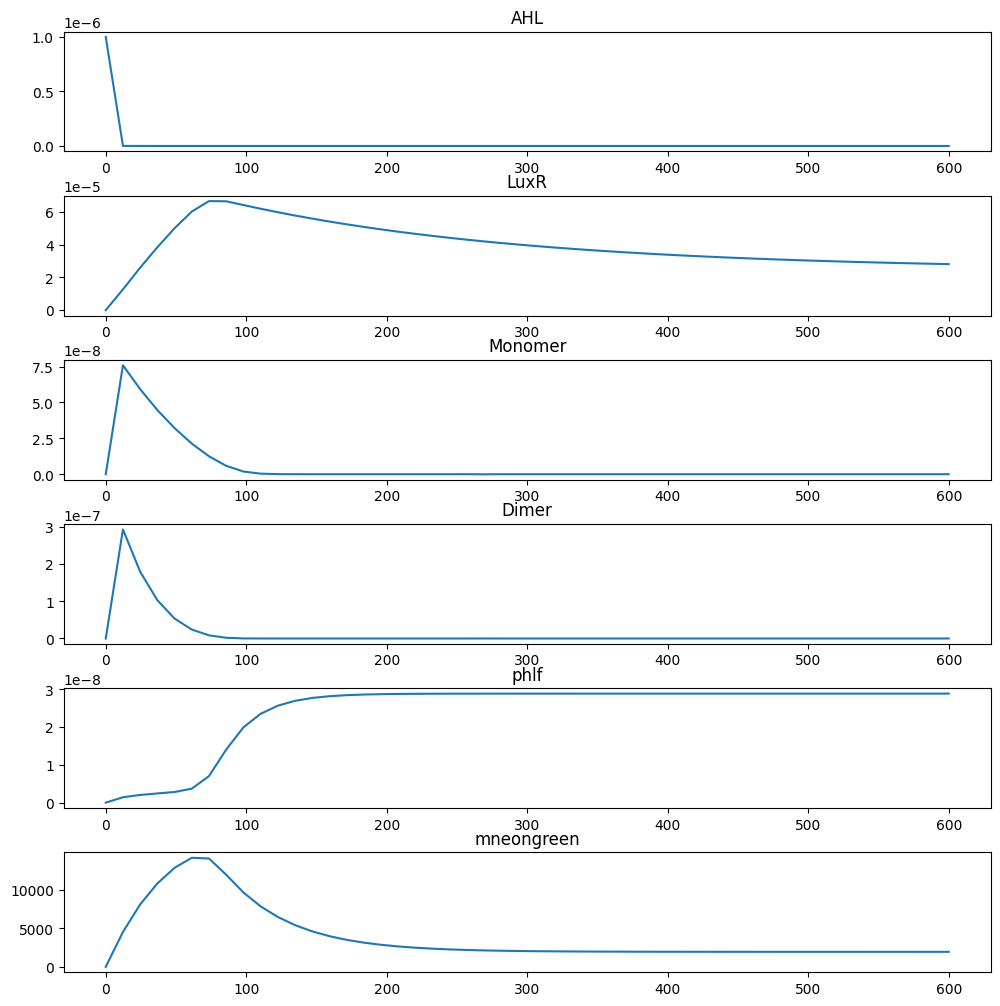

In [6]:
#single-cell time-values (with AHL in Molar)
small=1e-45
x0=[10**(-6),0,0,0,0,0] #AHL-LuxR-Mon-Dim-mng
solution=odeint(single_cell,x0,t)
fig,axs=plt.subplots(6,figsize=(10,10))
fig.tight_layout()
axs[0].plot(t,solution[:,0])
axs[0].set_title('AHL')
axs[1].plot(t,solution[:,1])
axs[1].set_title('LuxR')
axs[2].plot(t,solution[:,2])
axs[2].set_title('Monomer')
axs[3].plot(t,solution[:,3])
axs[3].set_title('Dimer')
axs[4].plot(t,solution[:,4])
axs[4].set_title('phlf')
axs[5].plot(t,solution[:,5])
axs[5].set_title('mneongreen')
print(max(solution[:,5]))

19901.580394231056


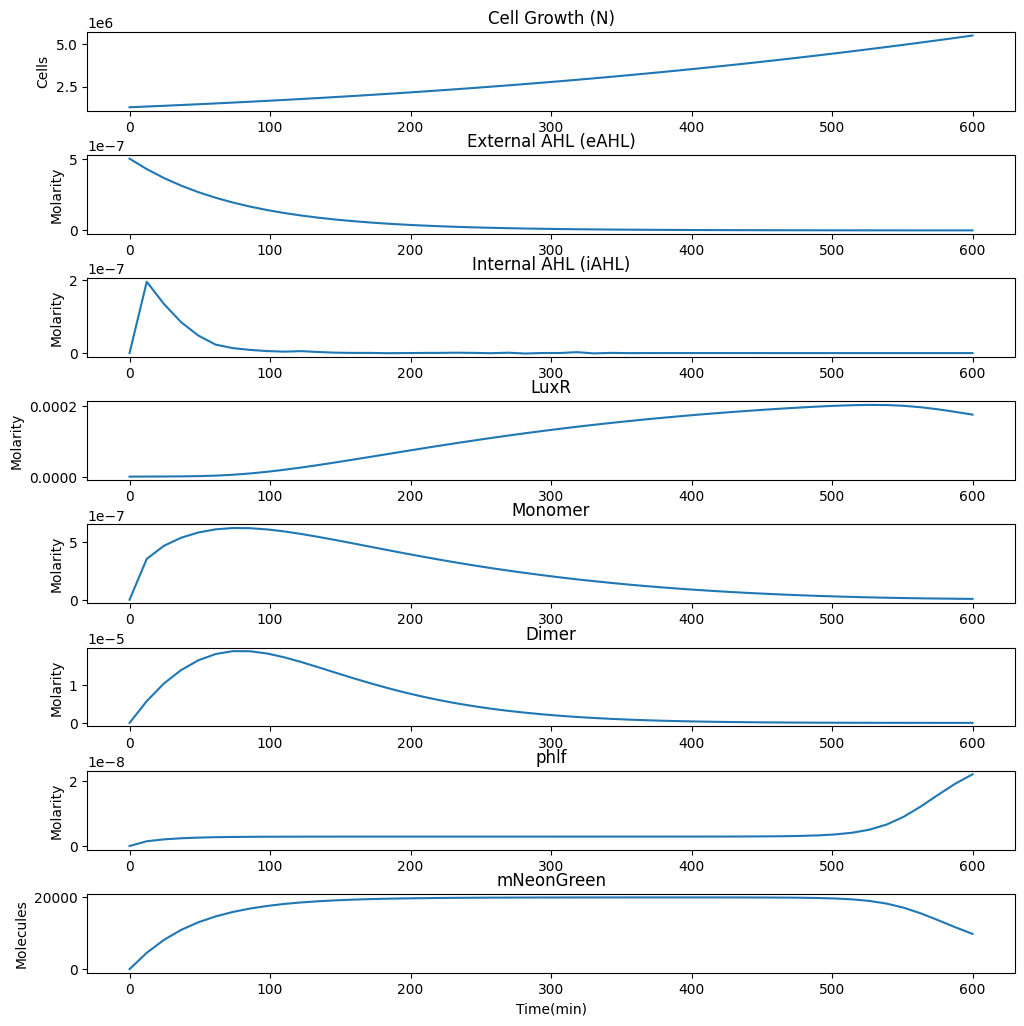

In [4]:
#whole-cell time-values (with AHL in M)
x0=[Nmin,5*10**(-7),0,0,0,0,0,0] #N-AHL_ext-AHL_int-LuxR-Mon-Dim-mng
solution=odeint(whole_cell,x0,t)
fig,axs=plt.subplots(8,figsize=(10,10))
fig.tight_layout()
axs[0].plot(t,solution[:,0])
axs[0].set_title('Cell Growth (N)')
axs[0].set_ylabel('Cells')
axs[1].plot(t,solution[:,1])
axs[1].set_title('External AHL (eAHL)')
axs[1].set_ylabel('Molarity')
axs[2].plot(t,solution[:,2])
axs[2].set_title('Internal AHL (iAHL)')
axs[2].set_ylabel('Molarity')
axs[3].plot(t,solution[:,3])
axs[3].set_title('LuxR')
axs[3].set_ylabel('Molarity')
axs[4].plot(t,solution[:,4])
axs[4].set_title('Monomer')
axs[4].set_ylabel('Molarity')
axs[5].plot(t,solution[:,5])
axs[5].set_title('Dimer')
axs[5].set_ylabel('Molarity')
axs[6].plot(t,solution[:,6])
axs[6].set_title('phlf')
axs[6].set_ylabel('Molarity')
axs[7].plot(t,solution[:,7])
axs[7].set_title('mNeonGreen')
axs[7].set_ylabel('Molecules')
axs[7].set_xlabel('Time(min)')
print(max(solution[:,7]))

Text(0.5, 1.0, 'TF Single Cell (PFR)')

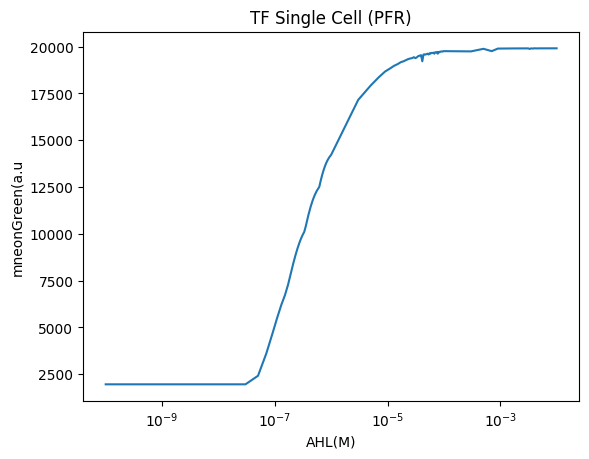

In [54]:
#Single-cell TF (with AHL in nM)
mng_temp=[]
AHL_values_0=np.linspace(10**(-10),10**(-8))
AHL_values_1=np.linspace(10**(-8),10**(-6))
AHL_values_2=np.linspace(10**(-6),10**(-4))
AHL_values_3=np.linspace(10**(-4),10**(-2))
AHL_values=np.concatenate([AHL_values_0,AHL_values_1,AHL_values_2,AHL_values_3])
for i in range(np.shape(AHL_values)[0]):
    x0=[AHL_values[i],0,0,0,0,0]
    solution=odeint(single_cell,x0,t)
    mng_temp.append(max(solution[:,5]))
plt.semilogx(AHL_values,mng_temp)
plt.xlabel('AHL(M)')
plt.ylabel('mneonGreen(a.u')
plt.title('TF Single Cell (PFR)')

Text(0.5, 1.0, 'TF Whole Cell (PFR)')

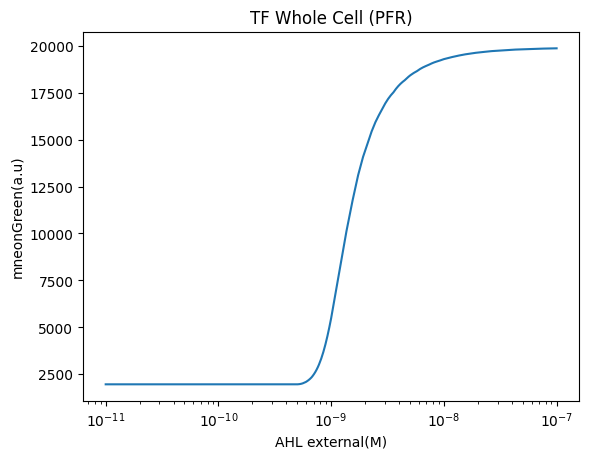

In [55]:
#Single-cell TF (with AHL in n)
mng_temp=[]
AHL_values_0=np.linspace(10**(-11),10**(-10))
AHL_values_1=np.linspace(10**(-10),10**(-9))
AHL_values_2=np.linspace(10**(-9),10**(-8))
AHL_values_3=np.linspace(10**(-8),10**(-7))
AHL_values=np.concatenate([AHL_values_0,AHL_values_1,AHL_values_2,AHL_values_3])
for i in range(np.shape(AHL_values)[0]):
    x0=[Nmin,AHL_values[i],0,0,0,0,0,0]
    solution=odeint(whole_cell,x0,t)
    mng_temp.append(max(solution[:,7]))
plt.semilogx(AHL_values,mng_temp)
plt.xlabel('AHL external(M)')
plt.ylabel('mneonGreen(a.u)')
plt.title('TF Whole Cell (PFR)')

In [56]:
#model_fit_functions
def f(x,t,paras):
    Ni=x[0]
    AHL_ext=x[1]
    AHL_int=x[2]
    LuxR=x[3]
    Mon=x[4]
    Dim=x[5]
    phlf=x[6]
    mng=x[7]
    
    
    try:
        a1 = paras['a1'].value
        a2= paras['a2'].value
        a3 = paras['a3'].value
        n = paras['n'].value
        b_pphlf=paras['b_pphlf'].value
        kdphlf=paras['kdphlf'].value
        d_phlf = paras['d_phlf'].value
        d_mrnaphlf = paras['d_mrnaphlf'].value


    except KeyError:
        a1,a2,a3,n,b_pphlf,kdphlf,d_phlf,d_mrnaphlf= paras
    
    dNdt=small+mi*Ni*(1-(Ni/Nmax))
    dAHL_extdt=small+D*Vc*Ni*(AHL_int-AHL_ext)-(d_AHL+mi)*AHL_ext
    dAHLdt=small+k_min_one*Mon-k1*AHL_int*LuxR -(d_AHL+mi)*AHL_int +D*Vc*10**(11)*(AHL_ext-AHL_int)
    dLuxRdt=small+ molar(((a1*CN))/(d_mrnaluxr+mi))*(b_plux+(1-b_plux)*((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))) - (d_luxr+mi)*LuxR + k_min_one*Mon - k1*LuxR*AHL_int
    dMondt=small+ (k1*LuxR*AHL_int+2*k_min_two*Dim-k_min_one*Mon-2*k2*(Mon**2)-(d_mon+mi)*Mon)
    dDimdt=small+ (k2*(Mon**2)-k_min_two*Dim-(d_dim+mi)*Dim)
    dphlfdt=small+molar((a2*CN)/(d_mrnaphlf+mi))*(b_plux+(1-b_plux)*((pow(abs(kdlux),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))) - d_phlf*phlf
    Hill_1=(b_pphlf+(1-b_pphlf)*((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n)))))
    Hill_2=(b_plux+(1-b_plux)*((pow(abs(kdphlf),n))/((pow(abs(phlf),n))+(pow(kdphlf,n)))))
    dmngdt =small+ ((a3*CN)/(d_mrnamng+mi))*Hill_1*Hill_2 - (d_mng+mi)*mng
    
    return [dNdt,dAHL_extdt,dAHLdt,dLuxRdt,dMondt,dDimdt,dphlfdt,dmngdt]

def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(paras,))
    return x

def residual(paras, t, data):
    mng_model=[]
    for i in range(len(x0_measured)):
        x0=[Nmin,x0_measured[i],0,0,0,0,0,0]
        model = g(t, x0, paras)
        mng_model.append(max(model[:,7]))
    mng_model=np.array(mng_model)
    data=np.array(data)
    print( paras['a1'].value,paras['a2'].value,paras['a3'].value,paras['n'].value,paras['b_pphlf'].value,paras['kdphlf'].value,paras['d_phlf'].value,paras['d_mrnaphlf'].value)
    print(mng_model)
    return (mng_model-data).ravel()

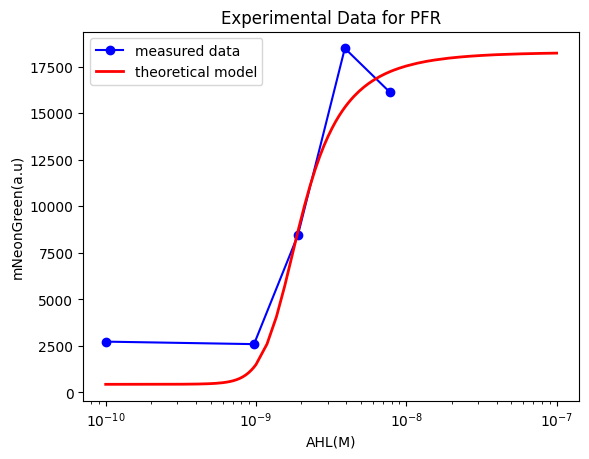

In [58]:
t_measured=[0,20,40,60,80,100,120,150,180,240,300,360]
x6_measured=[2720,2586,8445,18484,16114] #13381,13704,13396,13136 ]
x0_measured=np.array([1,9.7,19,39,78])*10**(-10) #312.5,625,1250,2500

plt.figure()
plt.semilogx(x0_measured, x6_measured, marker='o', color='b', label='measured data')
plt.xlabel('AHL(M)')
plt.ylabel('mNeonGreen(a.u)')
plt.title('Experimental Data for PFR')

params=Parameters()
params.add('a1',value=15, min=0.1,max=50)
params.add('a2', value=0.053, min=0.1, max=50)
params.add('a3', value=0.6588, min=0.1, max=50)
params.add('n',value=2,min=0.5,max=4)
params.add('b_pphlf',value=0.1,min=0,max=1)
params.add('kdphlf',value=2*10**(-7),min=10**(-12),max=10**(-6))
params.add('d_phlf',value=0.042,min=10**(-2),max=0.1)
params.add('d_mrnaphlf',value=1.2,min=10**(-2),max=0.1)

AHL_values_0=np.linspace(10**(-8),10**(-8),3)
AHL_values_1=np.linspace(10**(-8),10**(-7))
AHL_values_2=np.linspace(10**(-7),10**(-6))
AHL_values_3=np.linspace(10**(-6),10**(-5))
AHL_values=np.concatenate([AHL_values_0,AHL_values_1,AHL_values_2,AHL_values_3])*10**(-2)

mng_fit=[]


for i in range(153):
    y0=[Nmin,AHL_values[i],0,0,0,0,0,0]
    model_fit=g(np.linspace(0,360,100),y0,params)
    mng_fit.append(max(model_fit[:,7]))

plt.semilogx(AHL_values, mng_fit,linewidth=2,color='red',label='theoretical model')
plt.legend()
plt.show()




In [ ]:
result = minimize(residual, params, args=(t_measured, x6_measured),method='Nelder-Mead', tol=1e-6) #doesnt stop
print(result.params)

C:\Users\manos\AppData\Local\Temp\ipykernel_14332\342417039.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g^" (-> marker='^'). The keyword argument will take precedence.
  plt.semilogx(x0_measured, x6_measured,'g^', marker='o', color='b', label='measured data')
C:\Users\manos\AppData\Local\Temp\ipykernel_14332\342417039.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g^" (-> color='g'). The keyword argument will take precedence.
  plt.semilogx(x0_measured, x6_measured,'g^', marker='o', color='b', label='measured data')


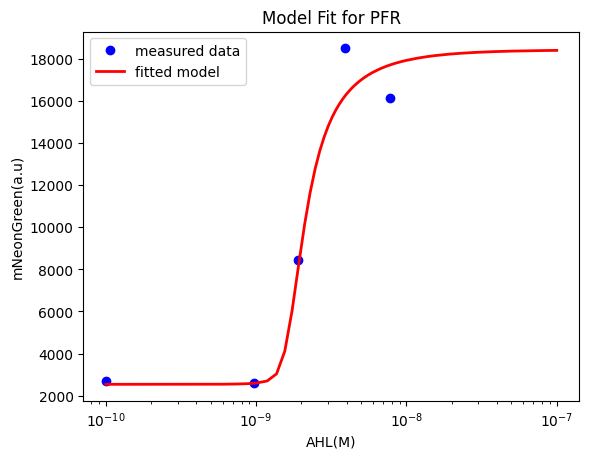

In [60]:
params['a1'].value=5.67
params['a2'].value=0.1
params['a3'].value=0.62
params['n'].value=2.31
params['b_pphlf'].value=0.36
params['kdphlf'].value= 7.95*10**(-7)
params['d_phlf'].value=0.03
params['d_mrnaphlf'].value=0.06

plt.figure()
plt.semilogx(x0_measured, x6_measured,'g^', marker='o', color='b', label='measured data')
plt.xlabel('AHL(M)')
plt.ylabel('mNeonGreen(a.u)')
plt.title('Model Fit for PFR')

AHL_values_0=np.linspace(10**(-8),10**(-8),3)
AHL_values_1=np.linspace(10**(-8),10**(-7))
AHL_values_2=np.linspace(10**(-7),10**(-6))
AHL_values_3=np.linspace(10**(-6),10**(-5))
AHL_values=np.concatenate([AHL_values_0,AHL_values_1,AHL_values_2,AHL_values_3])*10**(-2)

mng_fit=[]

for i in range(153):
    y0=[Nmin,AHL_values[i],0,0,0,0,0,0]
    model_fit=g(np.linspace(0,360,100),y0,params)
    mng_fit.append(max(model_fit[:,7]))

plt.semilogx(AHL_values, mng_fit,linewidth=2,color='red',label='fitted model')
plt.legend()
plt.show()
